# day 13 - Probabilistic Programming

# Demo 1: Hello world for linear regression in PyMC3

This is meant to be a first notebook for exploring how to use PyMC3 to do:

* MAP estimation
* MCMC sampling using Metropolis random-walk proposals

Inspired by:

* Bob Carpenter's blog post:

https://statmodeling.stat.columbia.edu/2017/05/31/compare-stan-pymc3-edward-hello-world/

* The "hello world" example in the PyMC3 journal article:

Salvatier, Wiecki, and Fonnesbeck. "Probabilistic programming in Python using PyMC3". 
https://peerj.com/articles/cs-55.pdf

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid');
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.0})

# Import PyMC


You may need to install it first

```console
$ micromamba activate spr_2024s_env
$ micromamba install -c conda-forge pymc
```

In [ ]:
import pymc
print(pymc.__version__)

5.8.1


# Model as MATH

We wish to consider a simple linear regression model.

Each individual example (indexed by $n$) has an output real value $y_n$. We model each observation as (conditionally) iid using a regression given one input feature $x_n$

### Likelihood

\begin{align}
 p(y_{1:N} | w) &= \prod_{n=1}^N \text{NormPDF}(y_n | w_1 + w_2 x_{n}, \beta^{-1})
\end{align}

The random variables of interest are the intercept $w_1$ and slope $w_2$.

The precision $\beta$ is a fixed hyperparameter.

### Priors on regression coefficients:
\begin{align}
 p(w_1) &= \text{NormalPDF}(0, var=9)
\\
 p(w_2) &= \text{NormalPDF}(0, var=9)
\end{align}

The prior precision $\alpha = \frac{1}{9}$ is a fixed hyperparameter

# Simulate data from the model


In [ ]:
# Initialize random number generator
np.random.seed(123)

# True regression coefficients
w_2 = np.asarray([1.337, -2.0])

# True hyperparameters
alpha = 1/9. # variance = 9 so stddev = 3
beta = 0.5

# Size of dataset
N = 100

# Data Features (input variable)
x1_N = 2 * np.random.randn(N)
x_N1 = np.hstack([x1_N[:,np.newaxis]])

# Simulate outcome variable
y_N = w_2[0] + w_2[1]*x1_N + np.sqrt(1/beta) * np.random.randn(N)

true_params = dict(
    w=w_2,
    alpha=alpha,
    beta=beta)

In [ ]:
def calc_post_params(N):
    global x_N1, y_N, alpha, beta
    M = 2
    phi_NM = np.hstack([np.ones((N,1)), x_N1[:N]])
    wcov_22 = np.linalg.inv(alpha * np.eye(M) + beta * np.dot(phi_NM.T, phi_NM))
    wmean_2 = beta * np.dot(wcov_22, np.dot(phi_NM.T, y_N[:N]))
    return dict(wmean_2=wmean_2, wcov_22=wcov_22)

In [ ]:
post_params_N0 = calc_post_params(0)
post_params_N3 = calc_post_params(3)

In [ ]:
post_params_N0

{'wmean_2': array([0., 0.]),
 'wcov_22': array([[9., 0.],
        [0., 9.]])}

In [ ]:
post_params_N3

{'wmean_2': array([ 1.05520278, -2.69585593]),
 'wcov_22': array([[ 0.62386821, -0.02630294],
        [-0.02630294,  0.21766003]])}

# Plot of observed data

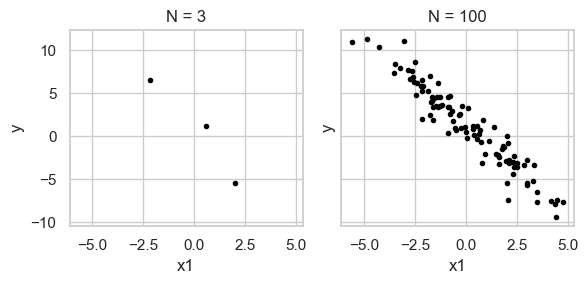

In [ ]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(6,3), sharex=True, sharey=True)
for plot_id, Ncur in enumerate([3, N]):
    ax = axgrid[plot_id]
    ax.plot(x1_N[:Ncur], y_N[:Ncur], 'k.');
    ax.set_xlabel('x1');
    ax.set_ylabel('y');
    ax.set_title("N = %d" % Ncur)
plt.tight_layout(); plt.subplots_adjust();

# Model specified as a PyMC3 object

In [ ]:
def make_model(N=0):
    my_model = pymc.Model()

    with my_model:
        # Priors for unknown model parameters
        wvec = pymc.Normal('w', mu=0, sigma=np.sqrt(1/alpha), size=2)
    
        # Likelihood (sampling distribution) of observations
        Y_obs = pymc.Normal('Y_obs',
            mu=(wvec[0] + wvec[1] * x1_N[:N]),
            sigma=np.sqrt(1/beta),
            observed=y_N[:N])
    return my_model

In [ ]:
my_model_N3 = make_model(N=3)

In [ ]:
my_model_N3.basic_RVs

[w ~ Normal(0, 3), Y_obs ~ Normal(f(w), 1.41)]

# Setup: Prepare for plotting results

In [ ]:
def plot_traces(trace_obj, true_params, map_params=None):
    fig, ax_grid = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), sharex=True, sharey=True);
    for ax, var_name, dim in zip(
            ax_grid.flatten(), ['w', 'w'], [0, 1]):
        var_samples_CS = trace_obj['posterior'][var_name].values
        true_val = true_params[var_name]

        if dim is not None:
            var_samples_S = var_samples_CS[0, :, dim].flatten()
            true_val = true_val[dim]
            if map_params is not None:
                map_val = map_params[var_name][dim]          
            var_name_dim = var_name + "[%d]" % dim
        else:
            var_name_dim = var_name
            var_samples_S = var_samples_CS.flatten()
            if map_params is not None:
                map_val = map_params[var_name]

        S = var_samples_S.size
        ax.plot(var_samples_S, 'b.', markersize=4, alpha=0.3, label='samples')
        ax.plot(true_val * np.ones(S), 'r-', label='true val')
        if map_params is not None:
            ax.plot(map_val * np.ones(S), 'b-', label='MAP val')
        ax.set_ylabel(var_name_dim)
        ax.set_xlabel('sampling step');

    ax.legend(loc='upper right')

# Run MAP estimator for small dataset

In [ ]:
def calc_MAP(N=None, my_model=None):
    if my_model is None:
        my_model = make_model(N)
    return pymc.find_MAP(model=my_model, maxeval=1000)

In [ ]:
map_N3 = calc_MAP(N=3)

## Display MAP weights found by PyMC

In [ ]:
for key, arr in map_N3.items():
    print(key, arr)

w [ 1.05520276 -2.69585585]


## MAP weights found by analytical formulas

In [ ]:
post_params_N3['wmean_2']

array([ 1.05520278, -2.69585593])

## True params used to generate data

In [ ]:
for key, arr in true_params.items():
    print(key, arr)

w [ 1.337 -2.   ]
alpha 0.1111111111111111
beta 0.5


# Run Metropolis RW MCMC sampler for small dataset

In [ ]:
def run_RW_sampler(rw_sigma=1.0, N=0, n_samples=10000, n_bins=31):

    my_model = make_model(N)
    post_params = calc_post_params(N)
    my_map = calc_MAP(my_model=my_model)
    
    with my_model:
        # instantiate sampler
        mcmc_step = pymc.Metropolis(S=rw_sigma**2 * np.ones(1), tune=False)
    
        # draw 1000 posterior samples
        trace = pymc.sample(
            draws=n_samples,
            step=mcmc_step,
            chains=1,
            tune=0,
            discard_tuned_samples=False)
        
    plot_traces(trace, map_params=my_map, true_params=true_params)
    plt.xlim([0, 3000]);
    
    # Plot histograms
    _, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(6,3), sharex=False, sharey=False)
    for dim in [0,1]:
        axgrid[dim].hist(
            trace['posterior']['w'].values[0,:,dim], n_bins, density=True)

        true_post_dist = scipy.stats.norm(
            post_params['wmean_2'][dim],
            np.sqrt(post_params['wcov_22'][dim,dim]))
        std = true_post_dist.std()
        wgrid_G = np.linspace(-5*std, 5*std, 301) + true_post_dist.mean()
        axgrid[dim].plot(wgrid_G, [true_post_dist.pdf(w) for w in wgrid_G], 'r-');        
        axgrid[dim].set_xlabel("w[%d]" % dim);
        axgrid[dim].set_ylabel('pdf');
        axgrid[dim].set_xlim([-4, 4]);
    plt.subplots_adjust(); plt.tight_layout();

Sequential sampling (1 chains in 1 job)
Metropolis: [w]


Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


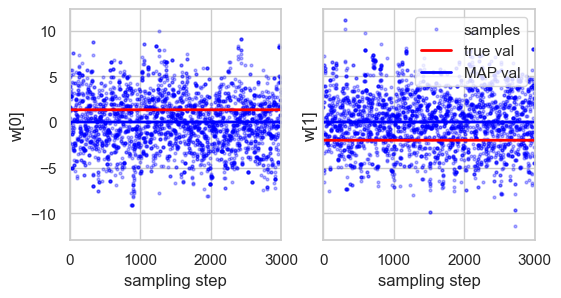

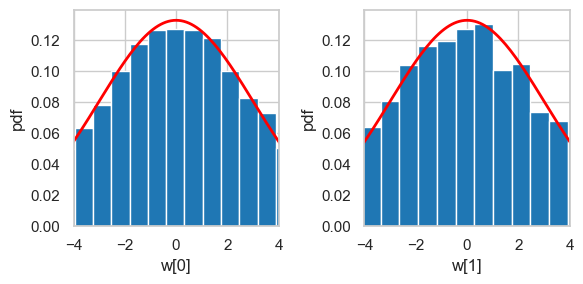

In [ ]:
run_RW_sampler(rw_sigma=2.0, N=0, n_samples=10000)

Sequential sampling (1 chains in 1 job)
Metropolis: [w]


Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


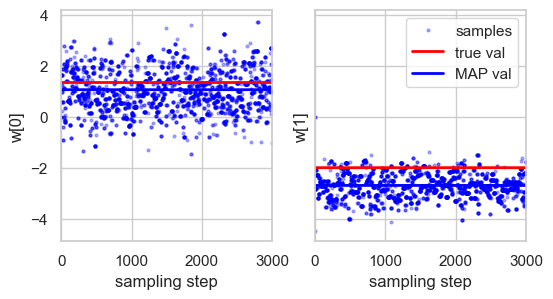

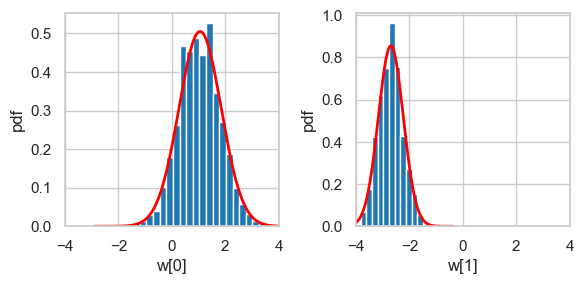

In [ ]:
run_RW_sampler(rw_sigma=2.0, N=3, n_samples=10000, n_bins=21)

Sequential sampling (1 chains in 1 job)
Metropolis: [w]


Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


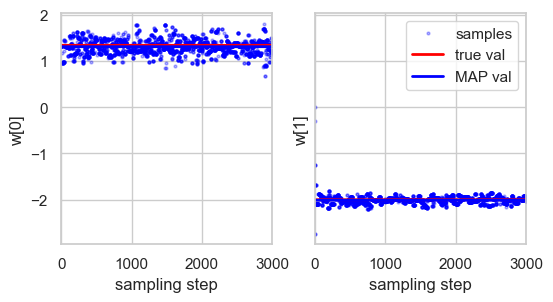

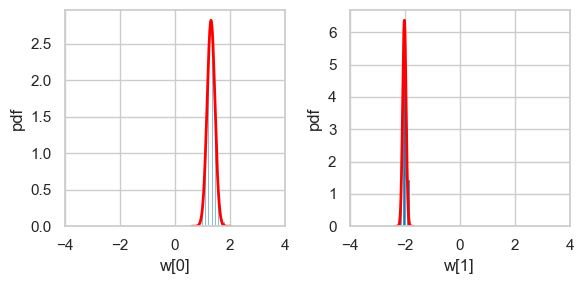

In [ ]:
run_RW_sampler(rw_sigma=1.0, N=100, n_samples=10000, n_bins=21)